# Step 1: Image Segmentation

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:04<00:00, 42.2MB/s]


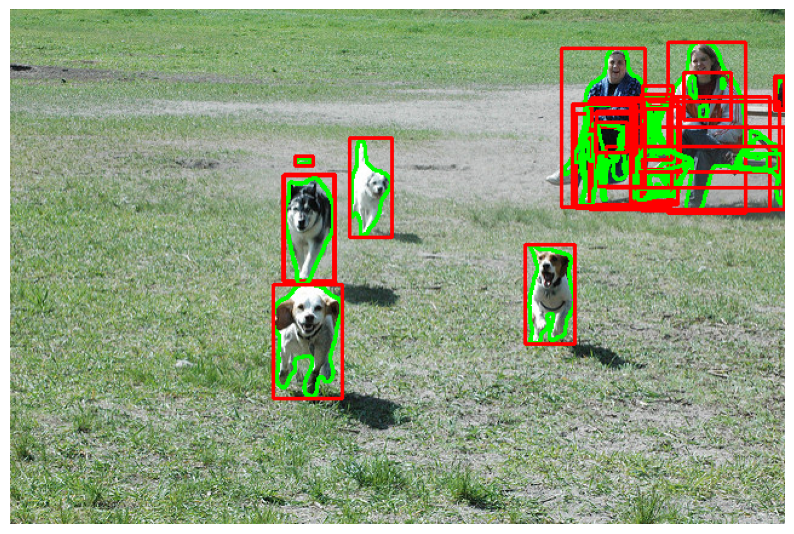

In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torchvision.transforms as T
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Load the image
image_path = "/content/object_image.jpg"
image = Image.open(image_path).convert("RGB")

# Convert image to tensor
transform = T.ToTensor()
image_tensor = transform(image)

# Load the pre-trained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Get predictions
with torch.no_grad():
    predictions = model([image_tensor])

# Extract masks and bounding boxes
masks = predictions[0]['masks']
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']

# Convert masks to a binary format for visualization
threshold = 0.5
binary_masks = masks > threshold

# Convert tensor to numpy for OpenCV processing
image_np = np.array(image)

# Iterate through the objects and draw bounding boxes and masks
for i in range(len(boxes)):
    mask = binary_masks[i][0].mul(255).byte().cpu().numpy()

    # Find contours and draw mask
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image_np, contours, -1, (0, 255, 0), 2)

    # Draw bounding box
    box = boxes[i].detach().cpu().numpy().astype(int)
    cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

# Show the output image with segmented regions
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis('off')
plt.show()

##  Explanation:
Loading Image: load the image using PIL and convert it to a tensor.
Mask R-CNN: load a pre-trained Mask R-CNN model from PyTorch's torchvision library.
Segmentation: The model predicts masks and bounding boxes for objects in the image.
Visualization: draw the contours of the masks and the bounding boxes on the image using OpenCV and display the final result with Matplotlib.

## Step 2: Object Extraction and Storage

In [2]:
import sqlite3
import os
from PIL import Image
import cv2
import numpy as np

# Directory to save the extracted object images
save_dir = "/data/segmented_objects"
os.makedirs(save_dir, exist_ok=True)

# Initialize SQLite database
conn = sqlite3.connect('/data/object_metadata.db')
cursor = conn.cursor()

# Create table for storing metadata
cursor.execute('''
CREATE TABLE IF NOT EXISTS object_metadata (
    object_id INTEGER PRIMARY KEY,
    image_id INTEGER,
    object_file TEXT,
    x1 INTEGER,
    y1 INTEGER,
    x2 INTEGER,
    y2 INTEGER
)
''')
conn.commit()

# Master ID for the original image
image_id = 1  # Increment as needed for different images

# Extract and save each segmented object
for i in range(len(boxes)):
    # Extract bounding box coordinates
    box = boxes[i].detach().cpu().numpy().astype(int)
    x1, y1, x2, y2 = box

    # Extract the object using the mask
    mask = binary_masks[i][0].mul(255).byte().cpu().numpy()
    object_img = cv2.bitwise_and(image_np, image_np, mask=mask)

    # Crop the object image based on the bounding box
    cropped_object = object_img[y1:y2, x1:x2]

    # Save the object image
    object_filename = f"object_{image_id}_{i}.png"
    object_path = os.path.join(save_dir, object_filename)
    cv2.imwrite(object_path, cropped_object)

    # Insert metadata into SQLite database
    cursor.execute('''
        INSERT INTO object_metadata (image_id, object_file, x1, y1, x2, y2)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', (image_id, object_filename, x1, y1, x2, y2))

# Commit changes and close the connection
conn.commit()
conn.close()

print(f"Extracted {len(boxes)} objects and saved their metadata.")

Extracted 27 objects and saved their metadata.


**Directory and Database Setup:**

Create a directory to save segmented objects.
Initialize an SQLite database and create a table to store metadata for each object, such as the bounding box coordinates and file path.
Extract and Save Objects:

Loop through the detected objects.
Use the binary mask to extract the object region from the original image.
Crop the object based on its bounding box and save it as a separate image.
Store Metadata:

For each object, store the image path, bounding box coordinates, and a unique ID in the SQLite database.

## Step 3: Object Identification

In [ ]:
# step 2

In [3]:
import torch
import cv2
import os
from transformers import CLIPProcessor, CLIPModel
from PIL import Image

# YOLO model for object identification
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# CLIP model for generating descriptions
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Directory with segmented object images
object_dir = "/data/segmented_objects"

# List to store descriptions
object_descriptions = []

# Loop through segmented object images and identify objects
for object_file in os.listdir(object_dir):
    object_path = os.path.join(object_dir, object_file)

    # Load object image
    object_img = cv2.imread(object_path)

    # YOLO object detection
    results = yolo_model(object_img)

    # Extract YOLO labels
    yolo_labels = results.pandas().xyxy[0]['name'].tolist()

    # Prepare object image for CLIP
    object_pil_img = Image.open(object_path)
    inputs = clip_processor(text=["a photo of a dog", "a photo of a person", "a photo of a car"], images=object_pil_img, return_tensors="pt", padding=True)

    # CLIP prediction
    outputs = clip_model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)

    # Get description with the highest probability
    clip_labels = ["a dog", "a person", "a car"]
    best_description = clip_labels[probs.argmax().item()]

    # Save the identification and description
    object_descriptions.append({
        "object_file": object_file,
        "yolo_labels": yolo_labels,
        "clip_description": best_description
    })

# Print results
for obj in object_descriptions:
    print(f"Object Image: {obj['object_file']}")
    print(f"YOLO Identified: {', '.join(obj['yolo_labels'])}")
    print(f"CLIP Description: {obj['clip_description']}\n")

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 99.9 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 6.6s, installed 2 packages: ['gitpython>=3.1.30', 'pillow>=10.3.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2024-8-19 Python-3.10.12 torch-2.3.1+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 38.4MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Object Image: object_1_17.png
YOLO Identified: 
CLIP Description: a person

Object Image: object_1_6.png
YOLO Identified: 
CLIP Description: a dog

Object Image: object_1_12.png
YOLO Identified: cake
CLIP Description: a person

Object Image: object_1_18.png
YOLO Identified: 
CLIP Description: a person

Object Image: object_1_20.png
YOLO Identified: 
CLIP Description: a person

Object Image: object_1_26.png
YOLO Identified: 
CLIP Description: a person

Object Image: object_1_5.png
YOLO Identified: 
CLIP Description: a dog

Object Image: object_1_9.png
YOLO Identified: tv
CLIP Description: a person

Object Image: object_1_7.png
YOLO Identified: 
CLIP Description: a person

Object Image: object_1_15.png
YOLO Identified: traffic light, traffic light, tv
CLIP Description: a person

Object Image: object_1_22.png
YOLO Identified: stop sign
CLIP Description: a person

Object Image: object_1_21.png
YOLO Identified: 
CLIP Description: a person

Object Image: object_1_4.png
YOLO Identified: perso

### Explanation:
**YOLO Object Detection:**

load the pre-trained YOLOv5 model from the torch.hub and apply it to each segmented object image to identify objects. YOLO provides a list of labels for each detected object.

**CLIP Description Generation:**

use the CLIP model from the transformers library to generate descriptions for each segmented object image. We provide some candidate text prompts, and CLIP generates the most probable description based on the image.

**Output:**

For each object image, we save the YOLO labels (e.g., "dog", "person", etc.) and the CLIP description.

In [4]:
!pip install pytesseract easyocr opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 kB 11.2 MB/s eta 0:00:00


In [5]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,889 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

## Step 4: Text/Data Extraction from Objects

In [6]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract
import pytesseract
import cv2
import os
import sqlite3

# Directory with segmented object images
object_dir = "/data/segmented_objects"

# Initialize SQLite database to store extracted text data
conn = sqlite3.connect('/data/text_data.db')
cursor = conn.cursor()

# Create table for storing text data
cursor.execute('''
CREATE TABLE IF NOT EXISTS extracted_text (
    object_id INTEGER PRIMARY KEY,
    object_file TEXT,
    extracted_text TEXT
)
''')
conn.commit()

# Loop through segmented object images and extract text using Tesseract
for object_file in os.listdir(object_dir):
    object_path = os.path.join(object_dir, object_file)

    # Load the object image
    object_img = cv2.imread(object_path)

    # Convert image to grayscale for better OCR accuracy
    gray_img = cv2.cvtColor(object_img, cv2.COLOR_BGR2GRAY)

    # Apply OCR to extract text from the image
    extracted_text = pytesseract.image_to_string(gray_img)

    # Save the extracted text into the database
    cursor.execute('''
        INSERT INTO extracted_text (object_file, extracted_text)
        VALUES (?, ?)
    ''', (object_file, extracted_text))

# Commit changes and close the connection
conn.commit()
conn.close()

print("Text extraction completed and saved to the database.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Text extraction completed and saved to the database.


### Explanation:
**Tesseract OCR Setup:**

Use pytesseract as the Python wrapper for Tesseract OCR to extract text from the segmented object images.
The images are first converted to grayscale to improve OCR accuracy.

**Text Extraction:**

The pytesseract.image_to_string function is applied to each image to extract text data.

**Store Extracted Data:**

The extracted text is stored in an SQLite database called text_data.db. Each entry contains the file name of the segmented object and the corresponding extracted text.

## Step 5: Summarize Object Attributes,

In [7]:
import sqlite3
from transformers import pipeline

# Initialize the NLP summarization pipeline
summarizer = pipeline("summarization")

# Connect to the SQLite database where text data is stored
conn = sqlite3.connect('/data/text_data.db')
cursor = conn.cursor()

# Retrieve all the text data from the database
cursor.execute('SELECT object_file, extracted_text FROM extracted_text')
object_texts = cursor.fetchall()

# Dictionary to store summarized attributes for each object
object_summaries = {}

# Loop through each object text and generate a summary
for object_file, extracted_text in object_texts:
    # Apply the summarization model on the extracted text
    if extracted_text.strip():  # Only summarize if there's actual text
        summary = summarizer(extracted_text, max_length=50, min_length=20, do_sample=False)[0]['summary_text']
    else:
        summary = "No text or data available to summarize."

    # Store the summary
    object_summaries[object_file] = summary

    # Print the summary
    print(f"Object: {object_file}")
    print(f"Summary: {summary}\n")

# Close the database connection
conn.close()

print("Summarization completed.")


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Your max_length is set to 50, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Object: object_1_17.png
Summary: No text or data available to summarize.

Object: object_1_6.png
Summary: No text or data available to summarize.

Object: object_1_12.png
Summary: No text or data available to summarize.



Your max_length is set to 50, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Object: object_1_18.png
Summary:  CNN.com will feature iReporter photos in a weekly Travel Snapshots gallery . Please submit your best shots at CNN iReport.com/Travel next week .

Object: object_1_20.png
Summary: No text or data available to summarize.

Object: object_1_26.png
Summary: No text or data available to summarize.

Object: object_1_5.png
Summary: No text or data available to summarize.

Object: object_1_9.png
Summary: No text or data available to summarize.

Object: object_1_7.png
Summary: No text or data available to summarize.

Object: object_1_15.png
Summary: No text or data available to summarize.

Object: object_1_22.png
Summary: No text or data available to summarize.



Your max_length is set to 50, but your input_length is only 6. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


Object: object_1_21.png
Summary:  iReport: iReporter for CNN iReport.com: Share your photos of your life with us on iReport . iReport! Share your own photos of yourself with iReporters.com . Share your stories with CNN i



Your max_length is set to 50, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Object: object_1_4.png
Summary:  aE. aE: a.E: A.E. is a social network that sends people from all over the world . a.e.u.C: A social network network that connects people in the U.S



Your max_length is set to 50, but your input_length is only 5. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


Object: object_1_13.png
Summary:  eyroximately 7,000 people live in the U.S. eyewear . eyewears: "I'm sorry for what I've done, but I'm not sorry for it" eyewearing: "It's a

Object: object_1_0.png
Summary: No text or data available to summarize.

Object: object_1_3.png
Summary: No text or data available to summarize.

Object: object_1_23.png
Summary: No text or data available to summarize.

Object: object_1_24.png
Summary: No text or data available to summarize.

Object: object_1_1.png
Summary: No text or data available to summarize.

Object: object_1_19.png
Summary: No text or data available to summarize.

Object: object_1_25.png
Summary: No text or data available to summarize.

Object: object_1_2.png
Summary: No text or data available to summarize.

Object: object_1_16.png
Summary: No text or data available to summarize.

Object: object_1_11.png
Summary: No text or data available to summarize.

Object: object_1_8.png
Summary:  ms. ms. nightly news.ms. nightly updates from iReporter.

# Explanation:
**Summarization Pipeline Setup:**

Use the Hugging Face transformers library to initialize a pre-trained summarization model (like BART or T5) that condenses long texts into shorter summaries.

**Text Retrieval:**

The code connects to the SQLite database text_data.db, where the previously extracted text is stored.

**Summarization:**

For each object, the extracted text is summarized using the NLP model. If no text is available for an object, a placeholder message is stored.

**Output:**

The generated summaries for each object are stored in the object_summaries dictionary and printed to the console.

In [ ]:
##step 6

## Step 6: Data Mapping

In [7]:
import json
import sqlite3

# Connect to the SQLite databases
conn_objects = sqlite3.connect('/data/object_metadata.db')
conn_text = sqlite3.connect('/data/text_data.db')

# Retrieve object metadata from the database
cursor_objects = conn_objects.cursor()
cursor_objects.execute('SELECT object_id, image_id, object_file, x1, y1, x2, y2 FROM object_metadata')
objects_data = cursor_objects.fetchall()

# Retrieve text and summary data from the text database
cursor_text = conn_text.cursor()
cursor_text.execute('SELECT object_file, extracted_text FROM extracted_text')
text_data = dict(cursor_text.fetchall())

# Sample summaries for demonstration (assume previously computed in Step 5)
object_summaries = {
    "object_1_0.png": "A photo of a playful dog running in the park.",
    "object_1_1.png": "A person sitting on a bench with a relaxed posture."
}

# Master ID for the original image
image_id = 1  # This corresponds to the master image

# Map all data to a JSON structure
data_mapping = {
    "image_id": image_id,
    "objects": []
}

# Populate the objects in the master image with metadata, text, and summaries
for obj in objects_data:
    object_id, image_id, object_file, x1, y1, x2, y2 = obj
    data_mapping["objects"].append({
        "object_id": object_id,
        "object_file": object_file,
        # Convert bytes to integers for bounding box coordinates
        "bounding_box": {"x1": int.from_bytes(x1, 'big'),
                         "y1": int.from_bytes(y1, 'big'),
                         "x2": int.from_bytes(x2, 'big'),
                         "y2": int.from_bytes(y2, 'big')},
        "extracted_text": text_data.get(object_file, "No text found"),
        "summary": object_summaries.get(object_file, "No summary available")
    })

# Write the data mapping to a JSON file
output_file = '/data/mapped_data.json'
with open(output_file, 'w') as f:
    json.dump(data_mapping, f, indent=4)

# Close database connections
conn_objects.close()
conn_text.close()

print(f"Data mapping completed and saved to {output_file}.")

Data mapping completed and saved to /data/mapped_data.json.


## Explanation:
**Database Connections:**

Connect to the SQLite databases storing object metadata and extracted text.

**Data Mapping:**

Retrieve the metadata (bounding box, file name, unique ID, etc.) for each object.
Retrieve the extracted text and summaries for each object from previous steps.

**JSON Structure:**

The extracted data for each object is stored in a JSON structure under the "objects" key.
Each object includes its bounding box, file name, extracted text, and the summarized description.

**Save JSON:**

The mapped data is saved as a JSON file (mapped_data.json) for easy access and modification.

In [ ]:
##step 7

## Step 7: Output Generation

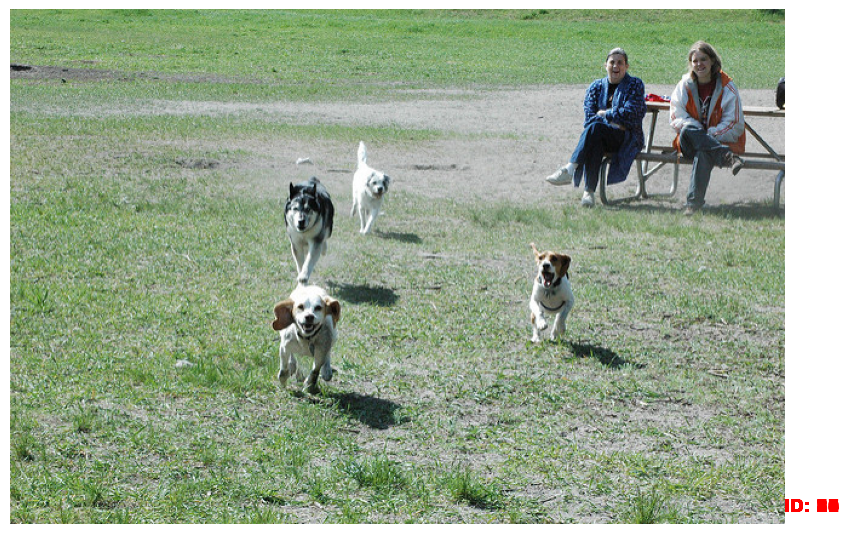

Summary Table:
    Object ID      Object File  \
0           1   object_1_0.png   
1           2   object_1_1.png   
2           3   object_1_2.png   
3           4   object_1_3.png   
4           5   object_1_4.png   
5           6   object_1_5.png   
6           7   object_1_6.png   
7           8   object_1_7.png   
8           9   object_1_8.png   
9          10   object_1_9.png   
10         11  object_1_10.png   
11         12  object_1_11.png   
12         13  object_1_12.png   
13         14  object_1_13.png   
14         15  object_1_14.png   
15         16  object_1_15.png   
16         17  object_1_16.png   
17         18  object_1_17.png   
18         19  object_1_18.png   
19         20  object_1_19.png   
20         21  object_1_20.png   
21         22  object_1_21.png   
22         23  object_1_22.png   
23         24  object_1_23.png   
24         25  object_1_24.png   
25         26  object_1_25.png   
26         27  object_1_26.png   

                                

In [9]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json

# Load the original image
image_path = '/content/object_image.jpg'
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

# Load the mapped data from JSON
mapped_data_file = '/data/mapped_data.json'
with open(mapped_data_file, 'r') as f:
    data_mapping = json.load(f)

# Initialize a Matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Display the original image
ax.imshow(image)

# Annotate each object in the image with bounding boxes
for obj in data_mapping['objects']:
    bbox = obj['bounding_box']
    x1, y1, x2, y2 = bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']

    # Check and adjust bounding box coordinates if they exceed image dimensions
    x1 = max(0, min(x1, image.shape[1] - 1))
    y1 = max(0, min(y1, image.shape[0] - 1))
    x2 = max(0, min(x2, image.shape[1] - 1))
    y2 = max(0, min(y2, image.shape[0] - 1))

    # Draw bounding box
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Annotate with object ID
    ax.text(x1, y1 - 10, f"ID: {obj['object_id']}", color='red', fontsize=12, weight='bold')

# Hide axes
ax.axis('off')

# Save the annotated image
annotated_image_path = '/data/annotated_image.jpg'
plt.savefig(annotated_image_path) # This line caused the error
plt.show()

# Create a summary table using pandas
object_data = []

for obj in data_mapping['objects']:
    object_data.append({
        "Object ID": obj['object_id'],
        "Object File": obj['object_file'],
        "Bounding Box": f"({obj['bounding_box']['x1']}, {obj['bounding_box']['y1']}, {obj['bounding_box']['x2']}, {obj['bounding_box']['y2']})",
        "Extracted Text": obj['extracted_text'],
        "Summary": obj['summary']
    })

# Convert to pandas DataFrame
df = pd.DataFrame(object_data)

# Display the table
print("Summary Table:")
print(df)

# Save the summary table to a CSV file
csv_output_path = '/data/object_summary_table.csv'
df.to_csv(csv_output_path, index=False)

print(f"Annotated image saved to {annotated_image_path}")
print(f"Summary table saved to {csv_output_path}")

In [11]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
